In [1]:
!pip install category_encoders==2.6.1

You should consider upgrading via the '/root/venv/bin/python -m pip install --upgrade pip' command.


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import category_encoders as ce
import matplotlib.pyplot as plt

from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor

In [11]:
course_df = pd.read_csv('./course_prepared.csv', header=0, encoding='unicode_escape')
course_df.drop(columns='Subj', inplace=True)
course_df.head()

,Course,Term,Term Yr,Class Yr,Dept Desc,Cap,Enrolled
0,CSC 111,Fall,2019,1,Computer Science,400,346
1,CSC 115,Fall,2019,1,Computer Science,150,130
2,CSC 115,Summer,2019,1,Computer Science,115,86
3,CSC 225,Fall,2019,2,Computer Science,215,197
4,CSC 225,Summer,2019,2,Computer Science,145,63


In [26]:
X_train, X_test = train_test_split(course_df, test_size=0.4, random_state=42)
print(f"Train: {len(X_train)}, Test: {len(X_test)}")

enrollment = X_train.drop(columns='Enrolled', axis='columns')
enrollment_labels = X_train['Enrolled'].copy()

Train: 132, Test: 88


In [27]:
# Separate our attributes depending on their desired transformations
num_attribs = ['Class Yr', 'Term Yr']
cat_attribs = ['Term', 'Dept Desc']
log_attribs = ['Cap']
basen_attribs = ['Course']

numeric_pipeline = Pipeline([
    ('scaler', StandardScaler())
])

categorical_pipeline = Pipeline([
    ('encoder', OneHotEncoder())
])

log_pipeline = Pipeline([
    ('log', FunctionTransformer(np.log, feature_names_out="one-to-one")),
    ('scaler', StandardScaler())
])

basen_pipeline = Pipeline([
    ('base_encoder', ce.BaseNEncoder(base=2, cols=basen_attribs))
])

preprocessing = ColumnTransformer([
    ('numeric_transformer', numeric_pipeline, num_attribs),
    ('categorical_transformer', categorical_pipeline, cat_attribs),
    ('ordinal_transformer', basen_pipeline, basen_attribs),
    ('log_transformer', log_pipeline, log_attribs),
], remainder='passthrough', verbose_feature_names_out=False)

In [28]:
enrollment_prepared = preprocessing.fit_transform(enrollment)

In [29]:
preprocessing.get_feature_names_out()

array(['Class Yr', 'Term Yr', 'Term_Fall', 'Term_Spring', 'Term_Summer',
       'Dept Desc_Computer Science',
       'Dept Desc_Electrical & Computer Engg',
       'Dept Desc_Engineering & Computer Science', 'Course_0', 'Course_1',
       'Course_2', 'Course_3', 'Course_4', 'Cap'], dtype=object)

In [30]:
forest_reg = make_pipeline(preprocessing, RandomForestRegressor(random_state=42))
forest_reg.fit(enrollment, enrollment_labels)

forest_predictions = forest_reg.predict(enrollment)

forest_rmses = -cross_val_score(forest_reg, 
                                enrollment,
                                enrollment_labels,
                                scoring="neg_root_mean_squared_error", 
                                cv=10)

np.mean(forest_rmses)

19.01885685339779

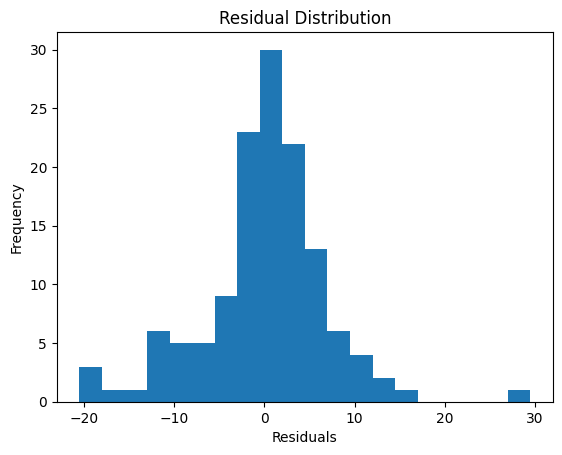

In [31]:
residuals = enrollment_labels - forest_predictions
plt.hist(residuals, bins=20)
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.title("Residual Distribution")
plt.show()

In [32]:
gb_reg = make_pipeline(preprocessing, GradientBoostingRegressor(random_state=42))
gb_reg.fit(enrollment, enrollment_labels)

gb_predictions = gb_reg.predict(enrollment)

gb_rmses = -cross_val_score(gb_reg, 
                            enrollment, 
                            enrollment_labels, 
                            scoring="neg_root_mean_squared_error", 
                            cv=10)

np.mean(gb_rmses)


18.716953974850856

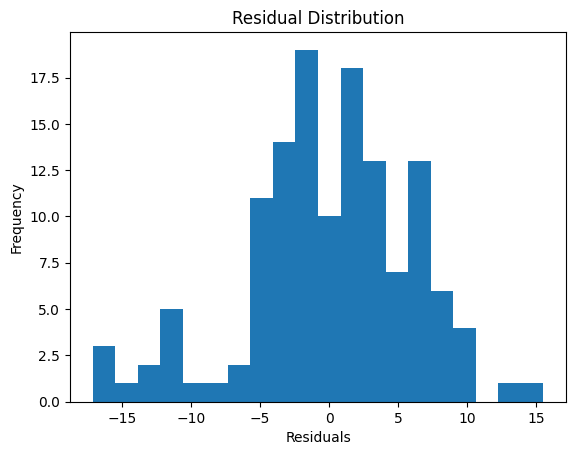

In [33]:
residuals = enrollment_labels - gb_predictions
plt.hist(residuals, bins=20)
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.title("Residual Distribution")
plt.show()

In [34]:
enrolled_predictions = gb_reg.predict(X_test)
final_mse = mean_squared_error(X_test['Enrolled'], enrolled_predictions, squared=False)
final_mse

43.46630458478708

In [35]:
X_test

,Course,Term,Term Yr,Class Yr,Dept Desc,Cap,Enrolled
132,CSC 320,Fall,2023,3,Computer Science,150,118
148,CSC 115,Summer,2020,1,Computer Science,210,159
93,CSC 361,Spring,2023,3,Computer Science,150,52
180,CSC 225,Spring,2019,2,Computer Science,176,130
15,CSC 370,Summer,2019,3,Computer Science,80,78
...,...,...,...,...,...,...,...
41,CSC 370,Spring,2020,3,Computer Science,150,99
135,CSC 361,Fall,2023,3,Computer Science,146,88
78,SENG 310,Fall,2022,3,Computer Science,78,76
178,CSC 111,Spring,2019,1,Computer Science,239,198


In [42]:
test = course_df[course_df['Term Yr'] == 2019]
test

,Course,Term,Term Yr,Class Yr,Dept Desc,Cap,Enrolled
0,CSC 111,Fall,2019,1,Computer Science,400,346
1,CSC 115,Fall,2019,1,Computer Science,150,130
2,CSC 115,Summer,2019,1,Computer Science,115,86
3,CSC 225,Fall,2019,2,Computer Science,215,197
4,CSC 225,Summer,2019,2,Computer Science,145,63
5,CSC 226,Fall,2019,2,Computer Science,140,87
6,CSC 226,Summer,2019,2,Computer Science,120,91
7,CSC 230,Fall,2019,2,Computer Science,200,149
8,CSC 230,Summer,2019,2,Computer Science,115,53
9,CSC 320,Fall,2019,3,Computer Science,174,166


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=ed8b2606-cddb-42a3-87b1-48ea02a39e44' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>